# ATE on Twitter: understand how well and what algorithms learn

The fact that ATE has never been used on Twitter (at least to the best of our knowledge) means that the first analysis has to be about understanding how well and what algorithms learn to be valid terms.

> Note that this analysis is not how ATE performs in general on Twitter, but how it performs in the context of event domains.
> A closer analysis how ATE performs in general domains that are not event-specific is by analyzing broader streams, such as #BreakingNews.

First, we load the necessary libraries and set the general stylesheet.

In [1]:
import importlib
import json
import math
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Polygon, Rectangle
import matplotlib.patheffects as pe
import numpy as np
import os
import pandas as pd
import statistics
import sys
import re

sys.path.append(os.path.expanduser("~/GitHub/multiplex-plot"))
sys.path = list(set(sys.path))

from multiplex import drawable
plt.style.use(os.path.join(os.getcwd(), '../modern-custom.style'))

names = { 'specificity': 'Domain Specificity', 'rank': 'Rank Difference', 'rank-50': 'Rank Difference',
          'tfidf': 'TF-ICF', 'tfidf-nva': 'TF-ICF (NVA)', 'tfidf-rt': 'TF-ICF (with RTs)', 
          'tfdcf': 'TF-DCF', 'tfdcf-rt': 'TF-DCF (with RTs)',
          'ef-idf-entropy': 'EVATE' }

data = os.path.expanduser('~/DATA/c4-ate/football/analyses/base/results-new-ap')
verified = os.path.expanduser('~/DATA/c4-ate/football/analyses/verified/results-new-ap')

Next, we load all the data from the files in the analysis directory.

In [2]:
# create the dataframe
df = pd.DataFrame(columns=[ 'method', 'precision', 'recall', 'f1', 'ap', 'p@k', 'terms', 'precise' ])

files = os.listdir(data) # the evaluation files
pattern = re.compile("([a-z0-9\-]+).json") # the extraction pattern (to get the number of events used to extract terms)

# load the data from the files in the directory
for file in files:
    with open(os.path.join(data, file)) as f:
        results = json.loads(f.readline())
        method = pattern.findall(file)[0]
        
        # get the summary results
        summary = results['results']['summary']
        p_k = sorted([ (int(k), precision) for k, precision in results['results']['p@k'].items() ],
                     key=lambda _pk: _pk[0])
        p_k = [ precision for _, precision in p_k ]
        terms = results['pcmd']['terms']
        precise = [ term for term in results['results']['precise'] if results['results']['precise'][term] ]
        
        # insert it all in the dataframe
        df.loc[len(df)] = { 'method': method,
                            'ap': summary['average precision'], 'precision': summary['precision'],
                            'recall': summary['recall'], 'f1': summary['f1'], 'p@k': p_k,
                            'terms': terms, 'precise': precise }

df = df.sort_values(by=['ap'], ascending=True)
df = df.set_index('method', drop=True)
df

,precision,recall,f1,ap,p@k,terms,precise
method,,,,,,,
specificity,0.215,0.052121,0.083902,0.009454,"[0, 0.0, 0.0, 0.0, 0.2, 0.16666666666666666, 0...","[psg, bayern, davi, mbapp, ucl, pogba, maguir,...","[ucl, handbal, refere, stretcher, bottler, str..."
tfidf,0.160,0.038788,0.062439,0.010030,"[0, 0.0, 0.0, 0.25, 0.2, 0.16666666666666666, ...","[arsen, bayern, chelsea, goal, lyon, neymar, p...","[goal, leagu, score, game, player, ucl, team, ..."
specificity-rt,0.195,0.047273,0.076098,0.011625,"[1, 0.5, 0.3333333333333333, 0.25, 0.2, 0.1666...","[ucl, psg, davi, maguir, bayern, mbapp, pogba,...","[ucl, kick-off, stretcher, handbal, refere, ha..."
rank,0.205,0.049697,0.080000,0.012588,"[0, 0.0, 0.0, 0.25, 0.2, 0.16666666666666666, ...","[arsen, chelsea, villa, midfield, neymar, ff, ...","[midfield, ucl, pitch, foul, bench, keeper, de..."
rank-rt,0.250,0.060606,0.097561,0.018399,"[0, 0.0, 0.0, 0.25, 0.2, 0.3333333333333333, 0...","[messi, arsen, chelsea, ucl, conced, midfield,...","[ucl, midfield, pitch, bench, foul, goalkeep, ..."
logef,0.240,0.058182,0.093659,0.018783,"[0, 0.5, 0.3333333333333333, 0.25, 0.4, 0.5, 0...","[fuck, half, finish, shit, pass, keeper, ball,...","[half, pass, keeper, ball, save, assist, goal,..."
tfdcf,0.205,0.049697,0.080000,0.019862,"[1, 1.0, 0.6666666666666666, 0.5, 0.6, 0.66666...","[goal, game, arsen, play, player, score, get, ...","[goal, game, player, score, win, team, footbal..."
tfdcf-rt,0.245,0.059394,0.095610,0.025371,"[1, 1.0, 1.0, 1.0, 0.8, 0.6666666666666666, 0....","[goal, score, game, player, arsen, play, live,...","[goal, score, game, player, team, season, win,..."
tfidf-nva,0.230,0.055758,0.089756,0.026364,"[1, 1.0, 1.0, 1.0, 0.8, 0.6666666666666666, 0....","[goal, score, game, player, arsen, play, team,...","[goal, score, game, player, team, win, footbal..."


**Conclusion:** All methods perform relatively similarly in terms of precision, recall and F-score, except for EF-ICF-Entropy.

The most discriminative metric is the average precision, which evaluates the rankings based on the order.
Aside from that, the precision, recall and F-score is consistent.
Only EF-ICF-Entropy rises above the baselines in this regard.

In [3]:
focus = [ 'specificity', 'rank', 'tfdcf', 'tfidf-nva', 'ef-idf-entropy' ] # methods to show
df[df.index.isin(focus)].sort_values(by='ap', ascending=False)

,precision,recall,f1,ap,p@k,terms,precise
method,,,,,,,
ef-idf-entropy,0.290,0.070303,0.113171,0.031892,"[0, 0.5, 0.6666666666666666, 0.5, 0.6, 0.5, 0....","[baller, keeper, offsid, ff, equalis, gol, goa...","[keeper, offsid, equalis, goalkeep, foul, ref,..."
tfidf-nva,0.230,0.055758,0.089756,0.026364,"[1, 1.0, 1.0, 1.0, 0.8, 0.6666666666666666, 0....","[goal, score, game, player, arsen, play, team,...","[goal, score, game, player, team, win, footbal..."
tfdcf,0.205,0.049697,0.080000,0.019862,"[1, 1.0, 0.6666666666666666, 0.5, 0.6, 0.66666...","[goal, game, arsen, play, player, score, get, ...","[goal, game, player, score, win, team, footbal..."
rank,0.205,0.049697,0.080000,0.012588,"[0, 0.0, 0.0, 0.25, 0.2, 0.16666666666666666, ...","[arsen, chelsea, villa, midfield, neymar, ff, ...","[midfield, ucl, pitch, foul, bench, keeper, de..."
specificity,0.215,0.052121,0.083902,0.009454,"[0, 0.0, 0.0, 0.0, 0.2, 0.16666666666666666, 0...","[psg, bayern, davi, mbapp, ucl, pogba, maguir,...","[ucl, handbal, refere, stretcher, bottler, str..."


## Retweets: bane or boon?

**Conclusion:** Retweets improve the quality of the rankings for all methods, but not enough to overcome EF-ICF-Entropy in terms of F1.

Retweets get a lot of flak: they are redundant, noisy and add bias.
However, the next visualization shows that what's a hindrance to other methods may not apply to ATE.
In fact, only TF-ICF does not perform better better when including retweets, and only marginally in terms of Average Precision.
All methods except benefit from improved F-score, except for Domain Specificity.

In [4]:
focus = [ 'ef-idf-entropy', 'tfdcf', 'tfdcf-rt', 'tfidf-nva', 'tfidf-rt',
          'specificity', 'specificity-rt', 'rank-50', 'rank-rt' ] # methods to show
df[df.index.isin(focus)].sort_values(by='ap', ascending=False)

,precision,recall,f1,ap,p@k,terms,precise
method,,,,,,,
ef-idf-entropy,0.290,0.070303,0.113171,0.031892,"[0, 0.5, 0.6666666666666666, 0.5, 0.6, 0.5, 0....","[baller, keeper, offsid, ff, equalis, gol, goa...","[keeper, offsid, equalis, goalkeep, foul, ref,..."
tfidf-rt,0.260,0.063030,0.101463,0.029787,"[1, 1.0, 1.0, 1.0, 0.8, 0.6666666666666666, 0....","[goal, score, player, game, messi, arsen, play...","[goal, score, player, game, season, team, win,..."
tfidf-nva,0.230,0.055758,0.089756,0.026364,"[1, 1.0, 1.0, 1.0, 0.8, 0.6666666666666666, 0....","[goal, score, game, player, arsen, play, team,...","[goal, score, game, player, team, win, footbal..."
tfdcf-rt,0.245,0.059394,0.095610,0.025371,"[1, 1.0, 1.0, 1.0, 0.8, 0.6666666666666666, 0....","[goal, score, game, player, arsen, play, live,...","[goal, score, game, player, team, season, win,..."
tfdcf,0.205,0.049697,0.080000,0.019862,"[1, 1.0, 0.6666666666666666, 0.5, 0.6, 0.66666...","[goal, game, arsen, play, player, score, get, ...","[goal, game, player, score, win, team, footbal..."
rank-rt,0.250,0.060606,0.097561,0.018399,"[0, 0.0, 0.0, 0.25, 0.2, 0.3333333333333333, 0...","[messi, arsen, chelsea, ucl, conced, midfield,...","[ucl, midfield, pitch, bench, foul, goalkeep, ..."
specificity-rt,0.195,0.047273,0.076098,0.011625,"[1, 0.5, 0.3333333333333333, 0.25, 0.2, 0.1666...","[ucl, psg, davi, maguir, bayern, mbapp, pogba,...","[ucl, kick-off, stretcher, handbal, refere, ha..."
specificity,0.215,0.052121,0.083902,0.009454,"[0, 0.0, 0.0, 0.0, 0.2, 0.16666666666666666, 0...","[psg, bayern, davi, mbapp, ucl, pogba, maguir,...","[ucl, handbal, refere, stretcher, bottler, str..."


The visualization shows how retweets lead to gains in performance.
These gains are not in the higher ranks, but they still improve the overall quality of the ranking.
This implies that it is the more technical terms that benefit from retweets.
Possibly, these technical terms, unlike those like *goal* or *score*, are used more predominantly by authoritative accounts.

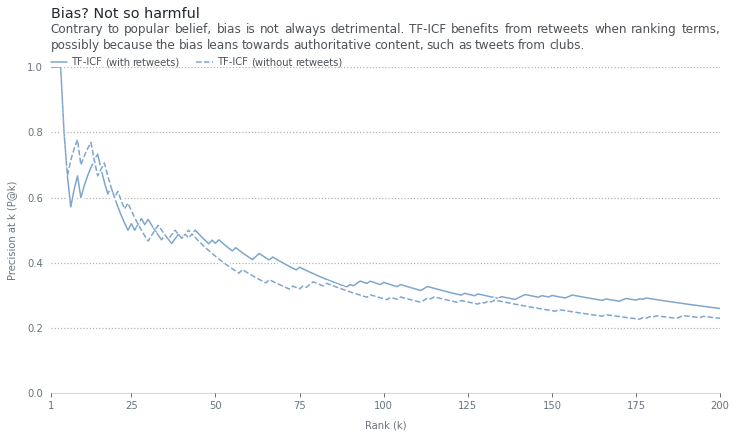

In [5]:
# create a general style
style = { 'with_legend': True, 'color': 'C1',
          'path_effects': [ pe.Stroke(linewidth=6, foreground='C4'), pe.Normal() ] }

# draw the visualization
figure = plt.figure(figsize=(12, 6))
viz = drawable.Drawable(figure)

x, y = range(1, len(df.loc['tfidf-rt']['p@k']) + 1), df.loc['tfidf-rt' ]['p@k']
viz.draw_time_series(x, y, 'TF-ICF (with retweets)', **style)
x, y = range(1, len(df.loc['tfidf-nva']['p@k']) + 1), df.loc['tfidf-nva' ]['p@k']
viz.draw_time_series(x, y, 'TF-ICF (without retweets)', linestyle='--', **style)
# x, y = range(1, len(df.loc['ef-idf-entropy']['p@k']) + 1), df.loc['ef-idf-entropy' ]['p@k']
# viz.draw_time_series(x, y, 'EF-ICF-Entropy', linestyle='-.', **style)

# x, y = range(1, len(df.loc['tfdcf-rt']['p@k']) + 1), df.loc['tfdcf-rt' ]['p@k']
# viz.draw_time_series(x, y, color='C2')
# x, y = range(1, len(df.loc['tfdcf']['p@k']) + 1), df.loc['tfdcf' ]['p@k']
# viz.draw_time_series(x, y, linestyle='--', color='C2')

# finalize the visualization
viz.set_xlim(min(x), max(x))
viz.set_xticks([ 1 ] + list(range(25, max(x) + 1, 25)))
viz.set_xlabel('Rank (k)')
viz.set_ylim(0, 1)
viz.set_ylabel('Precision at k (P@k)')
viz.set_title("Bias? Not so harmful", loc='left')
viz.set_caption(f"""Contrary to popular belief, bias is not always detrimental.
                    TF-ICF benefits from retweets when ranking terms, possibly because the bias leans towards authoritative content, such as tweets from clubs.""",
                align='justify')
viz.show()

**Conclusion:** Retweets may promote more authoritative content.

What do retweets represent?
That retweets introduce bias is only logical, but the repeated content does not seem to lean towards noise.
Instead, it re-inforces more domain terms.

One possible explanation is that retweets only diminish the cheap opinions.
Even though retweets may promote some popular opinions, it's likely that these popular opinions are coming from authoritative users with many followers.
As a result, they would be more expressive and descriptive, with more domain terms.

In fact, a more general explanation is that content from authoritative accounts spreads fast and wide.
A lot of this content comes from journalists, news media and the clubs themselves.
The point of these tweets is to describe what is happening, and thus describes the domain better.

What does this all mean?
That curation is very important when applying ATE on Twitter.

But what do retweets really change?
The next cell answers the question.

In [6]:
methods = [ ('tfidf-nva', 'tfidf-rt'), ('tfdcf', 'tfdcf-rt'),
            ('rank', 'rank-rt'), ('specificity', 'specificity-rt') ]

print(f"\033[1mTop risers (without RTs)\033[0m: terms that are higher without RTs than with RTs")
print(f"\033[1mTop risers (with RTs)\033[0m: terms that are higher with RTs than without RTs")
print(f"\033[1mNewcomers (with RTs)\033[0m: terms that only appear in the DF with RTs")
print(f"\033[1mNewcomers (without RTs)\033[0m: terms that only appear in the DF without RTs")
print()

show = 10
for method, method_rt in methods:
    print(f"\033[1m{ names.get(method, method) }\033[0m")
    _df0, _dfrt = df.loc[method], df.loc[method_rt]
    print(f"    \033[1mTop terms (without RT)\033[0m: { ', '.join(_df0.terms[:show]) }")
    print(f"    \033[1mTop terms (with RT)\033[0m: : { ', '.join(_dfrt.terms[:show]) }")
    print()
    
    # terms that are ranked low (high index) in the DF with retweets and ranked high (low index) in the DF without retweets
    # the next line measures upward movement from the DF with retweets to the DF without retweets
    movement = { term: _dfrt.terms.index(term) - _df0.terms.index(term) for term in _df0.terms
                                                                        if term in _dfrt.terms }
    risers = sorted(movement, key=movement.get, reverse=True)
    print(f"    \033[1mTop risers (without RTs)\033[0m: { ', '.join([ term for term in risers[:show] ]) }")
    
    # terms that are ranked high (low index) in the DF with retweets and ranked low (high index) in the DF without retweets
    # the next line measures upward movement from the DF without retweets to the DF with retweets
    movement = { term: _df0.terms.index(term) - _dfrt.terms.index(term) for term in _dfrt.terms
                                                                        if term in _df0.terms }
    risers = sorted(movement, key=movement.get, reverse=True)
    print(f"    \033[1mTop risers (with RTs)\033[0m: { ', '.join([ term for term in risers[:show] ]) }")
    print()
    
    newcomers = sorted([ term for term in _dfrt.terms if term not in _df0.terms ],
                       key=_dfrt.terms.index, reverse=False)
    print(f"    \033[1mChanged { len(newcomers) } terms\033[0m")
    print(f"    \033[1mNewcomers (with RTs)\033[0m: { ', '.join([ term for term in newcomers[:show] ]) }")
    lost = sorted([ term for term in _df0.terms if term not in _dfrt.terms ],
                    key=_df0.terms.index, reverse=False)
    print(f"    \033[1mNewcomers (without RTs)\033[0m: { ', '.join([ term for term in lost[:show] ]) }")
    print()

Top risers (without RTs): terms that are higher without RTs than with RTs
Top risers (with RTs): terms that are higher with RTs than without RTs
Newcomers (with RTs): terms that only appear in the DF with RTs
Newcomers (without RTs): terms that only appear in the DF without RTs

TF-ICF (NVA)
    Top terms (without RT): goal, score, game, player, arsen, play, team, win, footbal, get
    Top terms (with RT): : goal, score, player, game, messi, arsen, play, season, team, live

    Top risers (without RTs): luiz, shit, bad, ff, liverpool, pogba, greenwood, hope, keeper, class
    Top risers (with RTs): link, stream, messi, shot, support, conced, leav, lead, use, avlch

    Changed 33 terms
    Newcomers (with RTs): follow, enjoy, retweet, head, broadcast, record, goalkeep, home, career, competit
    Newcomers (without RTs): grealish, lol, bring, willian, mbapp, barca, noth, ref, martial, pep

TF-DCF
    Top terms (without RT): goal, game, arsen, play, player, score, get, win, team, good
  

The answer does not seem to be that retweets improve the ranking of correct terms as much as they penalize noise.
In fact, the majority of terms with the biggest drops or which dropped out of the top 200 are either player or team names, or informal words, like _tbf_ (to be fair), _mid_ (short for midfielder) and _cunt_.
Authoritative content, which we hypothesized as being retweeted more, is less likely to use acronyms, abbreviations or profanity, and has better orthography.
This minimizes the risk of POS tagging mistaking player names for verbs, nouns or adjectives.

**Conclusion:** Retweets help filter informal content.

## Verified users

In [7]:
# create the dataframe
vdf = pd.DataFrame(columns=[ 'method', 'precision', 'recall', 'f1', 'ap', 'p@k', 'terms', 'precise' ])

files = os.listdir(verified) # the evaluation files
pattern = re.compile("([a-z0-9\-]+).json") # the extraction pattern (to get the number of events used to extract terms)

# load the data from the files in the directory
for file in files:
    with open(os.path.join(verified, file)) as f:
        results = json.loads(f.readline())
        method = pattern.findall(file)[0]
        
        # get the summary results
        summary = results['results']['summary']
        p_k = sorted([ (int(k), precision) for k, precision in results['results']['p@k'].items() ],
                     key=lambda _pk: _pk[0])
        p_k = [ precision for _, precision in p_k ]
        terms = results['pcmd']['terms']
        precise = [ term for term in results['results']['precise'] if results['results']['precise'][term] ]
        
        # insert it all in the dataframe
        vdf.loc[len(vdf)] = { 'method': method,
                             'ap': summary['average precision'], 'precision': summary['precision'],
                             'recall': summary['recall'], 'f1': summary['f1'], 'p@k': p_k,
                             'terms': terms, 'precise': precise }

vdf = vdf.sort_values(by=['ap'], ascending=False)
vdf = vdf.set_index('method', drop=True)
vdf.loc['ef-idf-entropy'] = df.loc['ef-idf-entropy']
vdf

,precision,recall,f1,ap,p@k,terms,precise
method,,,,,,,
rank-50,0.425,0.103030,0.165854,0.042851,"[1, 0.5, 0.3333333333333333, 0.25, 0.4, 0.5, 0...","[ucl, chelsea, bbcfootbal, arsen, semi-fin, ha...","[ucl, semi-fin, half-tim, midfield, kick-off, ..."
rank,0.360,0.087273,0.140488,0.042743,"[1, 0.5, 0.3333333333333333, 0.25, 0.4, 0.5, 0...","[ucl, chelsea, bbcfootbal, arsen, penalti, sem...","[ucl, penalti, semi-fin, half-tim, champion, f..."
tfidf,0.315,0.076364,0.122927,0.041373,"[1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0....","[goal, score, game, player, penalti, ucl, seas...","[goal, score, game, player, penalti, ucl, seas..."
tfdcf,0.300,0.072727,0.117073,0.034204,"[1, 1.0, 0.6666666666666666, 0.75, 0.8, 0.8333...","[goal, score, bbcfootbal, game, ucl, player, f...","[goal, score, game, ucl, player, half, season,..."
ef-idf-entropy,0.290,0.070303,0.113171,0.031892,"[0, 0.5, 0.6666666666666666, 0.5, 0.6, 0.5, 0....","[baller, keeper, offsid, ff, equalis, gol, goa...","[keeper, offsid, equalis, goalkeep, foul, ref,..."
rank-20,0.320,0.077576,0.124878,0.025216,"[1, 0.5, 0.3333333333333333, 0.5, 0.6, 0.5, 0....","[ucl, chelsea, bbcfootbal, semi-fin, half-tim,...","[ucl, semi-fin, half-tim, kick-off, quarter-fi..."
specificity,0.225,0.054545,0.087805,0.017397,"[1, 1.0, 0.6666666666666666, 0.5, 0.4, 0.5, 0....","[ucl, kick-off, psg, bvb, davi, stretcher, liv...","[ucl, kick-off, stretcher, handbal, semi-fin, ..."


In [8]:
efidfentropy_not_rank = [ term for term in vdf.loc['ef-idf-entropy'].precise
                               if term not in vdf.loc['rank-50'].precise ]
print(f"\033[1mIn EF-ICF-Entropy, but not in Rank Difference ({ len(efidfentropy_not_rank) })\033[0m")
print(f"    { ', '.join(efidfentropy_not_rank) }")
print()

rank_not_efidfentropy = [ term for term in vdf.loc['rank-50'].precise
                               if term not in vdf.loc['ef-idf-entropy'].precise ]
print(f"\033[1mIn Rank Difference, but not in EF-ICF-Entropy ({ len(rank_not_efidfentropy) })\033[0m")
print(f"    { ', '.join(rank_not_efidfentropy) }")
print()

efidfentropy_not_tficf = [ term for term in vdf.loc['ef-idf-entropy'].precise
                               if term not in vdf.loc['tfidf'].precise ]
print(f"\033[1mIn EF-ICF-Entropy, but not in TF-ICF ({ len(efidfentropy_not_tficf) })\033[0m")
print(f"    { ', '.join(efidfentropy_not_tficf) }")
print()

tficf_not_efidfentropy = [ term for term in vdf.loc['tfidf'].precise
                               if term not in vdf.loc['ef-idf-entropy'].precise ]
print(f"\033[1mIn TF-ICF, but not in EF-ICF-Entropy ({ len(tficf_not_efidfentropy) })\033[0m")
print(f"    { ', '.join(tficf_not_efidfentropy) }")

In EF-ICF-Entropy, but not in Rank Difference (14)
    dive, foot, touch, sack, save, shock, shoot, nutmeg, book, hat, sitter, post, celebr, winner

In Rank Difference, but not in EF-ICF-Entropy (41)
    ucl, semi-fin, half-tim, kick-off, quarter-fin, aggreg, whistl, stadium, bench, stretcher, full-tim, restart, trophi, competit, visitor, match, flick, releg, squad, goalscor, coach, forward, tactic, season, fixtur, box, chanc, soccer, team, tie, manag, afc, game, derbi, oppon, format, convert, fan, replac, point, doubl

In EF-ICF-Entropy, but not in TF-ICF (21)
    offsid, ref, dive, foot, handbal, striker, sack, tackl, shock, deflect, shoot, nutmeg, clearanc, defenc, brace, hat, dribbl, sitter, post, celebr, winner

In TF-ICF, but not in EF-ICF-Entropy (26)
    game, ucl, season, team, match, chanc, start, semi-fin, fan, half-tim, point, kick-off, quarter-fin, competit, box, open, manag, bench, follow, aggreg, stadium, attack, restart, whistl, full-tim, support


## Do all methods learn the same?

At first glance from the dataframe above, there is not a remarkable range of results.
All methods—even EF-ICF-Entropy, relative to the methods that use retweets—identify roughly the same number of domain terms.
The next visualization focuses not on what makes the methods different, but on what they share.

**Conclusion:** The methods can be split into three groups: those which are overly-specific, those which are overly-general, and EF-ICF-Entropy in-between.

All of the methods presented here use only nouns, verbs and adjectives.
Nevertheless, Twitter's orthography means that these parts-of-speech aren't quite accurate.
The heatmap, focusing only on a few diverse methods, shows three groups:

1. The first group is made up of Domain Specificity and Rank Difference—both methods that favour specificity.
   The results are, predictably, reminiscent of Chung (2003)'s specificity scale mapped to events.
   The rankings are largely made up of named entities, especially towards the top.
   
2. The second group, with TF-ICF and TF-DCF, performs markedly better.
   They do not focus so much on specificity, so there are fewer named entities.
   However, their overlap is on the other end of the spectrum: general terms.
   Some of these are related to events, but superficial (like *game*).
   Others are just noisy, like *love*, *please* and *go*.
   
3. The third group is EF-ICF-Entropy's.
   This group shares very little overlap with all other methods, but it still out-performs them.
   This behaviour indicates that EF-ICF-Entropy's approach is sound, even though it chases a different set of terms.

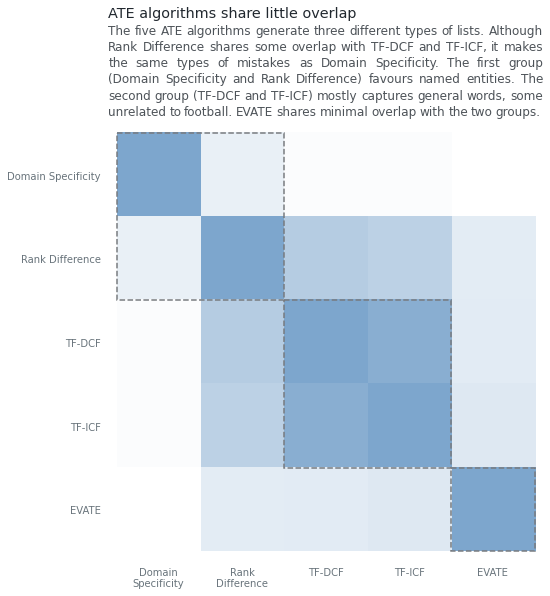

In [9]:
# prepare the data
# focus = [ 'specificity', 'rank', 'tfdcf-rt', 'tfidf-rt', 'ef-idf-entropy' ] # methods to show
focus = [ 'specificity', 'rank-50', 'tfdcf', 'tfidf', 'ef-idf-entropy' ] # methods to show
linestyle = { 'linewidth': 1.5, 'edgecolor': 'C3', 'facecolor': 'none', 'linestyle': '--' }
_df = vdf[vdf.index.isin(focus)]
use = 200 # the number of terms to use
intersection = [
    [ len(set(_df.loc[i].terms[:use]).intersection(set(_df.loc[j].terms[:use])))
        for j in focus ]
    for i in focus ]

# overlap = set(_df.loc['tfdcf-rt'].terms[:use]).intersection(set(_df.loc['tfidf-rt'].terms[:use]))
# print(overlap)

# create a style (mainly, the color map)
_min, _max = (125, 166, 205, 0), (125, 166, 205, 255)
samples = 100
rgba = np.ones((samples, 4))
for i in range(4):
    rgba[:, i] = np.linspace(_min[i]/255, _max[i]/255, samples)
cmap = ListedColormap(rgba)

# draw the visualization
figure = plt.figure(figsize=(8, 8))
viz = drawable.Drawable(figure)
viz.imshow(intersection, cmap=cmap)

# add a border around the three groups
xlim, ylim = viz.get_xlim(), viz.get_ylim()
pad = 0.1
viz.set_xlim(xlim[0]-pad, xlim[1]+pad)
viz.set_ylim(ylim[0]+pad, ylim[1]-pad)
viz.add_patch(Rectangle((-0.5, -0.5), 2, 2, **linestyle))
viz.add_patch(Rectangle((1.5, 1.5), 2, 2, **linestyle))
viz.add_patch(Rectangle((3.5, 3.5), 1, 1, **linestyle))

# finalize the visualization
viz.grid(False)
viz.set_xticks(range(len(focus)))
viz.set_xticklabels([ names.get(method, method).replace(' ', '\n', 1) for method in focus ])
viz.axes.spines['bottom'].set_visible(False)
plt.tick_params(axis='both', which='both', bottom=False, labelbottom=True)
viz.set_yticks(range(len(focus)))
viz.set_yticklabels([ names.get(method, method) for method in focus ])
viz.set_title("ATE algorithms share little overlap", loc='left')
viz.set_caption(f"""The five ATE algorithms generate three different types of lists.
                    Although Rank Difference shares some overlap with TF-DCF and TF-ICF, it makes the same types of mistakes as Domain Specificity.
                    The first group (Domain Specificity and Rank Difference) favours named entities.
                    The second group (TF-DCF and TF-ICF) mostly captures general words, some unrelated to football.
                    EVATE shares minimal overlap with the two groups.""",
                align='justify')
viz.savefig('../exports/4.3-base-overlap.png', dpi=300, bbox_inches='tight')

## What *do* the methods learn then?

The unresolved question, then, is: what are the latter two groups learning that give them relatively similar results with such different rankings?
Before we answer that question, the next visualization shows just how far apart TF-ICF (with retweets) and EF-ICF-Entropy, which are the two best-performing methods, rank terms.

**Conclusion:** EF-ICF-Entropy has very little overlap with TF-ICF; the former learns specific concepts and the latter learns general concepts.

As if further confirmation is needed, beyond the overlap, the first term among EF-ICF-Entropy's top 10 terms that appears in TF-ICF's ranking, *goalkeeper*, is only ranked 93rd.
In other words, all of EF-ICF-Entropy's top 10 terms are ranked 93rd or below.

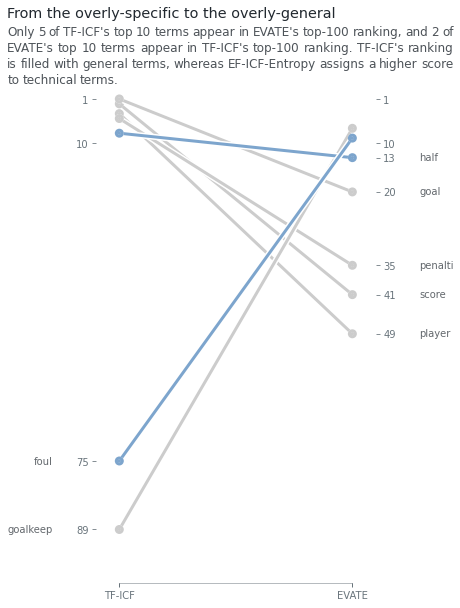

In [10]:
# set up the style
style.pop('with_legend', None)
style.update({ 'linewidth': 3, 'marker': 'o', 'markersize': 3, 'markeredgewidth': 6, 'color': 'C5' })
highlight = dict(style)
highlight.update({ 'color': 'C1', 'zorder': 999 })
annotation_style = { 'fontsize': 'smaller', 'alpha': 0.7, 'pad': 0 }

# prepare the data
methods = ('tfidf', 'ef-idf-entropy') # the methods to contrast
use = 100 # the number of terms to consider from the first and second rankings
focus = 10 # the number of top-ranked terms to look for

lhs = vdf.loc[methods[0]].terms[:use]
rhs = vdf.loc[methods[1]].terms[:use]
lslopes = [ (r + 1, rhs.index(term) + 1) for r, term in enumerate(lhs[:focus]) if term in rhs ]
lslopes = sorted(lslopes, key=lambda slope: slope[1], reverse=True) # sort in descending order of the rank in the second method
rslopes = [ (lhs.index(term) + 1, r + 1) for r, term in enumerate(rhs[:focus]) if term in lhs ]
rslopes = sorted(rslopes, key=lambda slope: slope[0], reverse=True) # sort in descending order of the rank in the first method
slopes = set(lslopes + rslopes)

# draw the visualization
figure = plt.figure(figsize=(8, 9))
viz = drawable.Drawable(figure)

# draw the slope going from method 1 to method 2
y1, y2 = [ slope[0] for slope in lslopes ], [ slope[1] for slope in lslopes ]
y1_ticks = [ _y1 if _y1 > 10 else '' for _y1 in y1 ]
y2_ticks = [ _y2 if _y2 > 10 else '' for _y2 in y2 ]
labels = [ lhs[_y1 - 1] for _y1 in y1 ]
if len(lslopes) > 1:
    viz.draw_slope(y1=y1[:-1], y2=y2[:-1], y1_tick=y1_ticks[:-1], y2_tick=y2_ticks[:-1],
                   label=labels[:-1], where='right', label_style=annotation_style, **style)
viz.draw_slope(y1=y1[-1], y2=y2[-1], y1_tick=y1_ticks[-1], y2_tick=y2_ticks[-1],
               label=labels[-1], where='right', label_style=annotation_style, **highlight)

# draw the slope going from method 2 to method 1
y1, y2 = [ slope[0] for slope in rslopes ], [ slope[1] for slope in rslopes ]
y1_ticks = [ _y1 if _y1 > 10 else '' for _y1 in y1 ]
y2_ticks = [ _y2 if _y2 > 10 else '' for _y2 in y2 ]
labels = [ rhs[_y2 - 1] for _y2 in y2 ]
if len(rslopes) > 1:
    viz.draw_slope(y1=y1[:-1], y2=y2[:-1], y1_tick=y1_ticks[:-1], y2_tick=y2_ticks[:-1],
                   label=labels[:-1], where='left', label_style=annotation_style, **style)
viz.draw_slope(y1=y1[-1], y2=y2[-1], y1_tick=y1_ticks[-1], y2_tick=y2_ticks[-1],
               label=labels[-1], where='left', label_style=annotation_style, **highlight)

# finalize the visualization
viz.axes.set_ylim(0, use)
viz.secondary.set_ylim(0, use)
viz.axes.set_yticks(list(set(list(viz.axes.get_yticks()) + [ 1, 10 ])))
viz.secondary.set_yticks(list(set(list(viz.secondary.get_yticks()) + [ 1, 10 ])))
viz.axes.set_yticklabels(viz.axes.get_yticks())
viz.secondary.set_yticklabels(viz.secondary.get_yticks())
viz.axes.invert_yaxis()
viz.secondary.invert_yaxis()
viz.set_xticklabels([ names.get(method, method) for method in methods ])
viz.set_title("From the overly-specific to the overly-general", loc='left')
viz.set_caption(f"""Only { len(lslopes) } of TF-ICF's top { focus } terms appear in { names.get(methods[1], method[1]) }'s top-{ use } ranking, and
                    { len(rslopes) } of { names.get(methods[1], method[1]) }'s top { focus } terms appear in TF-ICF's top-{ use } ranking.
                    TF-ICF's ranking is filled with general terms, whereas EF-ICF-Entropy assigns a higher score to technical terms.""",
                align='justify')
viz.savefig('../exports/4.3-base-top-terms.png', dpi=300, bbox_inches='tight')

The number of slopes—just 4—is a testament to how TF-ICF and EF-ICF-Entropy value different types of terms.
Because of its focus on term frequency, the former ranks highly many general terms, like *goal*, *score*, *player* and *team*.
While these terms are valid, they are also very general and hardly describe the complexity of a domain like football matches.

EF-ICF-Entropy does not fall to this trap.
By eliminating the term frequency, it promotes terms like *offside*, ranked 3rd in its ranking, while TF-ICF ranks it at rank 873.

## Confirming our intuition

While the previous point, that EF-ICF-Entropy learns more technical terms than TF-ICF, makes sense, it is based on observation.
The next, short experiment, considers what it means for a term to be technical.
The first consideration is that monosemous words (words with one meaning) are technical terms (Ha and Hyland, 2017).
In the next cell, we look at how many meanings words extracted by TF-ICF and EF-ICF-Entropy have on average.

First, we create maps to transform stemmed terms back to their lexical variations.

Second, we create a map between these terms and their corresponding synonym set.
**These mappings are manually-defined** and transform terms into the most accurate syonym set.
Note that football is transformed into _soccer_ because it is more specific than _football_.

Third, we map all terms and load the synonym sets.

In [11]:
from nltk.corpus import wordnet as wn

term_map = { 'goalkeep': 'goalkeeper', 'footbal': 'football', 'penalti': 'penalty', 'conced': 'concede',
             'offsid': 'offside', 'equalis': 'equalizer', 'freekick': 'free_kick', 'gol': 'goal', 'minut': 'minute' }
synset_map = { 'goal': 'goal.n.4', 'score': 'score.n.10', 'player': 'player.n.1', 'game': 'game.n.02',
               'season': 'season.n.1', 'team': 'team.n.1', 'win': 'win.n.1', 'play': 'play.v.01',
               'football': 'football.n.1', 'penalty': 'penalty.n.4', 'match': 'match.n.2', 'minute': 'minute.n.1',
               'fan': 'fan.n.2', 'ball': 'ball.n.1', 'keeper': 'goalkeeper.n.1', 'gol': 'goal.n.4',
               'goalkeeper': 'goalkeeper.n.1', 'offside': 'offside.n.1', 'equalizer': 'equalizer.n.3',
               'foul': 'foul.n.1', 'ref': 'referee.n.1', 'half': 'half.n.2', 'assist': 'assist.n.2',
               'sub': 'substitute.n.2', 'free_kick': 'free_kick.n.1', 'finish': 'finish.n.9' }
synset_map.update({ 'football': 'soccer.n.1' })

methods = ( 'tfidf', 'ef-idf-entropy' ) # the methods to compare
focus = 20 # the number of terms to consider from the top of the rankings

terms = list(set([ term for method in methods for term in vdf.loc[method].terms[:focus] ]))
terms = [ term_map.get(term, term) for term in terms ]
synsets = { term: wn.synsets(term) for term in terms }
synsets = { term: synsets for term, synsets in synsets.items() if synsets }

**Conclusion:** EF-ICF-Entropy's top terms are more 'technical', meaning they have fewer possible meanings.

The next statistics show how, on average, TF-ICF's top 20 terms have more than twice the number of meanings as EF-ICF-Entropy's top 20 terms.
This gets us closer to confirming the intuition that TF-ICF's terms are, indeed, more broadly-used outside of football.

In [12]:
for method in methods:
    _terms = vdf.loc[method].terms[:focus]
    _terms = [ term_map.get(term, term) for term in _terms ]
    _synsets = {  term: synsets[term] for term in _terms if term in synsets }
    unresolved = [ term for term in _terms if term not in _synsets ]

    print(f"\033[1m{ names.get(method, method) }\033[0m")
    print(f"{ len(unresolved) } concepts could not be resolved: { ', '.join(unresolved) }")
    print(f"{ len(_synsets) } resolved: { ', '.join( _synsets) }")
    print(f"{ round(statistics.mean([ len(meanings) for meanings in _synsets.values() ]), 2) } meanings on average")
    print(f"{ round(statistics.median([ len(meanings) for meanings in _synsets.values() ]), 2) } median number of meanings")
    print(f"{ round(statistics.stdev([ len(meanings) for meanings in _synsets.values() ]), 2) } standard deviation on means")
    print("")

TF-ICF
3 concepts could not be resolved: ucl, 're, bbcfootbal
17 resolved: goal, score, game, player, penalty, season, half, team, first, play, win, minute, match, ball, lead, football, time
13.06 meanings on average
8 median number of meanings
12.6 standard deviation on means

EVATE
2 concepts could not be resolved: baller, ff
17 resolved: keeper, offside, equalizer, goal, goalkeeper, var, foul, yellow, ref, ball, half, assist, concede, sub, free_kick, finish, brilliant
5.47 meanings on average
4 median number of meanings
4.82 standard deviation on means



A clear example of this is the difference between the meanings of _goalkeeper_ and _offside_, and _game_.
The first two are only common in sports, and even though they have meanings that are not exclcusive to football, there are only a bunch of them.
Conversely, _game_ has far more meanings, many not even related to sports.

In [13]:
for synset in synsets['goalkeeper']:
    print(f"\033[1m{synset.name()}\033[0m: { synset.definition() }")
    
print()

for synset in synsets['offside']:
    print(f"\033[1m{synset.name()}\033[0m: { synset.definition() }")

print()

for synset in synsets['score']:
    print(f"\033[1m{synset.name()}\033[0m: { synset.definition() }")

goalkeeper.n.01: the soccer or hockey player assigned to protect the goal
goalkeeper.n.02: the defensive position on an ice hockey or soccer or lacrosse team who stands in front of the goal and tries to prevent opposing players from scoring

offside.n.01: (sport) the mistake of occupying an illegal position on the playing field (in football, soccer, ice hockey, field hockey, etc.)
offside.a.01: illegally beyond a prescribed line or area or ahead of the ball or puck
offside.r.01: illegally in advance of the ball or puck

mark.n.01: a number or letter indicating quality (especially of a student's performance)
score.n.02: a written form of a musical composition; parts for different instruments appear on separate staves on large pages
score.n.03: a number that expresses the accomplishment of a team or an individual in a game or contest
score.n.04: a set of twenty members
score.n.05: grounds
score.n.06: the facts about an actual situation
score.n.07: an amount due (as at a restaurant or bar

**Conclusion:** EF-ICF-Entropy's top terms are much deeper in WordNet's hierarchy than TF-ICF's because they are more specific.

Another aspect of technicality is how specialized the meaning of a term is.
The more specialized the meaning, the deeper it would be in WordNet's tree.

The next cell shows that this is also the case.
On average, both the shortest and longest paths from the root to the corresponding synonym sets are longer for EF-ICF-Entropy than for TF-ICF.

> Note: **_gol_ and _goal_ reduce to _goal_**.
>       This is why the number of resolved and unresolved terms might not add up.

In [14]:
synsets = { }
for method in methods:
    _terms = vdf.loc[method].terms[:focus]
    _terms = [ term_map.get(term, term) for term in _terms ]
    _synsets = { term: wn.synset(synset_map.get(term))
                 for term in _terms
                 if term in synset_map }
    synsets.update(_synsets)
    unresolved = [ term for term in _terms if term not in _synsets ]
    
    print(f"\033[1m{ names.get(method, method) }\033[0m")
    for _term, _synset in _synsets.items():
        print(f"    { _term }: { _synset.min_depth() }")
    
    print(f"{ len(unresolved) } concepts could not be resolved: { ', '.join(unresolved) }")
    print(f"{ len(_synsets) } resolved: { ', '.join(_synsets) }")
    print(re.sub("\s+", ' ',
                 f"""Average depth: \
                     { round(statistics.mean([ synset.min_depth() for synset in _synsets.values() ]), 2) } –\
                     { round(statistics.mean([ synset.max_depth() for synset in _synsets.values() ]), 2) }"""))
    print(re.sub("\s+", ' ',
                 f"{ round(statistics.stdev([ synset.min_depth() for synset in _synsets.values() ]), 2) } –\
                   { round(statistics.stdev([ synset.max_depth() for synset in _synsets.values() ]), 2) } standard deviation for the min–max depth"))
    print("")

TF-ICF
    goal: 10
    score: 9
    game: 6
    player: 5
    penalty: 7
    season: 5
    half: 8
    team: 6
    play: 1
    win: 7
    minute: 4
    match: 6
    ball: 8
    football: 10
6 concepts could not be resolved: ucl, 're, bbcfootbal, first, lead, time
14 resolved: goal, score, game, player, penalty, season, half, team, play, win, minute, match, ball, football
Average depth: 6.57 – 6.93
2.44 – 2.67 standard deviation for the min–max depth

EVATE
    keeper: 7
    offside: 7
    equalizer: 10
    goal: 10
    goalkeeper: 7
    foul: 8
    ref: 6
    ball: 8
    half: 8
    assist: 9
    sub: 6
    free_kick: 12
    finish: 10
6 concepts could not be resolved: baller, ff, var, yellow, concede, brilliant
13 resolved: keeper, offside, equalizer, goal, goalkeeper, foul, ref, ball, half, assist, sub, free_kick, finish
Average depth: 8.31 – 9.23
1.8 – 1.3 standard deviation for the min–max depth



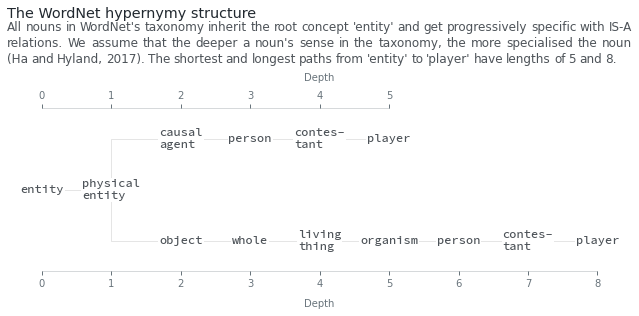

In [15]:
# create a style for the annotations
astyle = { 'alpha': 0.8, 'align': 'center', 'ha': 'left', 'va': 'center', 'fontfamily': 'Source Code Pro',
           'fontsize': '12', 'fontweight': 500, 'facecolor': 'C4', 'color': 'C0' }
style = dict(style)
style.update({ 'linewidth': .5, 'marker': 'None', 'color': 'C5', 'drawstyle': 'steps-pre' })
if style.get('path_effects'):
    del style['path_effects']
name_pattern = re.compile('([a-z_]+?)\.')

# choose the term and get the synset details
term = 'player'
synset = synsets[term]
paths = synset.hypernym_paths()
paths = sorted(paths, key=len)
depth = (synset.min_depth(), synset.max_depth())
    
# create the visualization
figure = plt.figure(figsize=(synset.max_depth() * 1.4, len(paths) * 1.5))
viz = drawable.Drawable(figure)

# draw the first node
viz.annotate('entity', x=(-0.5, 0.5), y=len(paths)/2., **astyle)

def draw_node(paths, x, y):
    """
    Draw a node in a tree.
    
    :param paths: The list of paths departing from the given node.
    :type paths: list of paths
    :param x: the x position of this tree
    :type x: int
    :param y: The y-bounds of the node, used to disect the tree.
    :type y: tuple
    """
    
    height = y[1] - y[0] # find the height of the current tree
    paths = [ path[1:] for path in paths ] # chop off the first part of the path
    subtrees = set([ path[0] for path in paths if len(path) ]) # find the forks of the tree
    
    # draw each subtree
    for i, subtree in enumerate(subtrees):        
        # find the bounds of the subtree
        _y = (y[0] + height * i / len(subtrees),
              y[0] + height *(i + 1) / len(subtrees),)

        name = name_pattern.findall(subtree.name())[0]
        name = name.replace('_', '\n')
        name = f"{ name[:6] }-\n{ name[6:] }" if len(name) > 8 and '\n' not in name else name
        viz.annotate([ name ], # draw the actual subtree
                     x=(x-0.5, x+0.5), y=(_y[0] + _y[1])/2, **astyle)
        
        _paths = [ path for path in paths if len(path) and path[0] == subtree ] # choose the relevant paths
        viz.plot([ x - 1, x ], [ (y[0] + y[1])/2, (_y[0] + _y[1])/2 ], **style) # draw a link between the nodes
        draw_node(_paths, x+1, _y) # recursively draw the rest of the nodes
    
# draw the entire tree
draw_node(paths, 1, (0.5, len(paths) - 0.5))

# style the visualization
viz.set_xlim(-0.5, synset.max_depth() + 0.5)
viz.set_ylim(0.6, len(paths)-0.6)
viz.axes.xaxis.set_label_position('top')
viz.axes.xaxis.tick_top()
viz.axes.spines['top'].set_visible(True)
viz.axes.spines['top'].set_bounds(0, synset.min_depth())
viz.axes.spines['bottom'].set_visible(False)
viz.axes.spines['bottom'].set_bounds(0, synset.max_depth())
viz.get_yaxis().set_visible(False)
viz.set_xticks(range(0, synset.min_depth() + 1))
viz.set_xlabel('Depth')

ax2 = viz.axes.secondary_xaxis('bottom')
ax2.set_xlim(-0.5, synset.max_depth() + 0.5)
ax2.set_xticks(range(0, synset.max_depth() + 1))
ax2.set_xticks(range(0, synset.max_depth() + 1))
ax2.spines['bottom'].set_bounds(0, synset.max_depth())
ax2.set_xlabel('Depth')

viz.grid(False)
viz.set_title("The WordNet hypernymy structure", loc='left')
viz.set_caption(f"""All nouns in WordNet's taxonomy inherit the root concept 'entity' and get progressively specific with IS-A relations.
                    We assume that the deeper a noun's sense in the taxonomy, the more specialised the noun (Ha and Hyland, 2017).
                    The shortest and longest paths from 'entity' to '{ name_pattern.findall(synset.name())[0] }' have lengths of { synset.min_depth() } and { synset.max_depth() }.""",
                align='justify')
viz.savefig('../exports/4.3-hypernymy-structure.png', dpi=300, bbox_inches='tight')